In [1]:
# === Generate corrected sparse GT files for line3_scaled ===
# This cell filters out empty ROIs and saves GTMasks_2 as (pixels, N_valid_ROIs)

import os
import sys
import numpy as np
from scipy.io import savemat, loadmat
import h5py
from scipy import sparse

# Access SUNS config
sys.path.insert(0, 'suns')
from config import DATAFOLDER_SETS, EXP_ID_SETS, ACTIVE_EXP_SET, OUTPUT_FOLDER, MAG, RATE_HZ

line3_scaled_root = DATAFOLDER_SETS['line3_scaled']
scaled_gt_folder = os.path.join(line3_scaled_root, 'GT Masks')
os.makedirs(scaled_gt_folder, exist_ok=True)

print("=== REGENERATING SPARSE GT FILES (line3_scaled) ===")
print(f"GT folder: {scaled_gt_folder}")

summary = []

for vid_id in EXP_ID_SETS['line3_scaled']:
    dense_path = os.path.join(scaled_gt_folder, f"FinalMasks_{vid_id}.mat")
    sparse_path = os.path.join(scaled_gt_folder, f"FinalMasks_{vid_id}_sparse.mat")

    if not os.path.exists(dense_path):
        print(f"✗ Missing dense GT: {dense_path}")
        continue

    # Load dense masks (handle v7.3 HDF5 and v7 MAT)
    masks = None
    try:
        with h5py.File(dense_path, 'r') as f:
            if 'FinalMasks' in f:
                arr = np.array(f['FinalMasks'])  # Could be (Ly, Lx, n)
                if arr.ndim == 3:
                    # MATLAB HDF5 is (Ly, Lx, n) → convert to (n, Ly, Lx)
                    masks = np.transpose(arr, (2, 0, 1)).astype(bool)
            elif 'GTMasks_2' in f:
                arr = np.array(f['GTMasks_2'])
                # Assume saved as (pixels, n)
                masks = np.transpose(arr, (1, 0)).astype(bool).reshape(arr.shape[1], -1)
    except OSError:
        pass

    if masks is None:
        md = loadmat(dense_path)
        if 'FinalMasks' in md:
            arr = np.array(md['FinalMasks'])
            # MATLAB v7 dense often loads as (Ly, Lx, n)
            if arr.ndim == 3:
                masks = np.transpose(arr, (2, 0, 1)).astype(bool)
        elif 'GTMasks_2' in md:
            arr = np.array(md['GTMasks_2'])
            masks = np.transpose(arr, (1, 0)).astype(bool).reshape(arr.shape[1], -1)

    if masks is None:
        print(f"✗ Could not read FinalMasks for {vid_id}")
        continue

    if masks.ndim != 3:
        print(f"✗ Unexpected mask dims for {vid_id}: {masks.shape}")
        continue

    n, ly, lx = masks.shape
    flat = masks.reshape(n, ly * lx)
    keep = np.any(flat, axis=1)
    num_kept = int(keep.sum())
    num_removed = int((~keep).sum())

    # Create sparse with shape (pixels, n_valid)
    reshaped = flat[keep].T  # (Ly*Lx, n_valid)
    sparse_mat = sparse.csc_matrix(reshaped.astype(np.uint8))

    savemat(sparse_path, {'GTMasks_2': sparse_mat}, do_compression=True)

    print(f"{vid_id}: dense (n, Ly, Lx)={masks.shape} → kept {num_kept}, removed {num_removed}; saved sparse {sparse_mat.shape}")
    summary.append((vid_id, (ly, lx, n), num_kept, sparse_mat.shape))

print("\n=== SUMMARY (line3_scaled) ===")
print("Mouse    | Dense (Ly, Lx, n) | Kept ROIs | Sparse shape")
print("-" * 60)
for vid_id, dense_shape, kept, sp_shape in summary:
    print(f"{vid_id:<8} | {str(dense_shape):<16} | {kept:<9} | {str(sp_shape)}")

print("\n✓ Done. Now run the visualization/summary cells below to verify counts (e.g., mouse7 → 69 ROIs).")


importing config
=== REGENERATING SPARSE GT FILES (line3_scaled) ===
GT folder: /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_scaled/GT Masks
mouse1: dense (n, Ly, Lx)=(477, 120, 88) → kept 42, removed 435; saved sparse (10560, 42)
mouse3: dense (n, Ly, Lx)=(713, 120, 88) → kept 50, removed 663; saved sparse (10560, 50)
mouse5: dense (n, Ly, Lx)=(494, 120, 88) → kept 62, removed 432; saved sparse (10560, 62)
mouse6: dense (n, Ly, Lx)=(968, 120, 88) → kept 59, removed 909; saved sparse (10560, 59)
mouse7: dense (n, Ly, Lx)=(1104, 120, 88) → kept 69, removed 1035; saved sparse (10560, 69)
mouse9: dense (n, Ly, Lx)=(398, 120, 88) → kept 36, removed 362; saved sparse (10560, 36)
mouse10: dense (n, Ly, Lx)=(611, 120, 88) → kept 30, removed 581; saved sparse (10560, 30)
mouse12: dense (n, Ly, Lx)=(454, 120, 88) → kept 33, removed 421; saved sparse (10560, 33)
mouse14: dense (n, Ly, Lx)=(591, 120, 88) → kept 47, removed 544; saved sparse (10560, 47)

=== SUMMARY (line3_scaled) ===
M

# Data Analysis and Scaling Notebook

This notebook performs the following tasks in order:
1. Plot max frame, resolution, and frame dimensions for demo/data YST datasets
2. Plot max frame, resolution, and frame dimensions for demo/line3_dataset
3. Scale line3_dataset to match demo/data resolution and dimensions
4. Plot max frame before and after upsampling for comparison


In [2]:
# === Helpers: reconstruct GT masks list and draw labeled contours ===
from typing import List

def load_gt_masks_list(gt_mat_path: str, dims: tuple) -> np.ndarray:
    """Return GT masks as array (n_gt, Lx, Ly) of bool.
    Expects 'GTMasks_2' sparse with shape (Ly*Lx, n_gt) or (n_gt, Ly*Lx).
    """
    Lx, Ly = dims
    md = loadmat(gt_mat_path)
    GT = md.get('GTMasks_2', None)
    if GT is None:
        raise RuntimeError(f"'GTMasks_2' not found in {gt_mat_path}")
    GT = csc_matrix(GT)
    pixels = Lx * Ly
    # Orient as (pixels, n)
    if GT.shape[0] == pixels and GT.shape[1] != pixels:
        oriented = GT
    elif GT.shape[1] == pixels and GT.shape[0] != pixels:
        oriented = GT.transpose()
    else:
        if GT.shape[0] == pixels and GT.shape[1] == pixels:
            oriented = GT
        else:
            raise RuntimeError(f"Unexpected GT shape {GT.shape} for dims {Lx}x{Ly}")
    n_gt = oriented.shape[1]
    masks = np.zeros((n_gt, Lx, Ly), dtype=bool)
    oriented = oriented.tocsc()
    for j in range(n_gt):
        col = oriented.getcol(j)
        if col.nnz == 0:
            continue
        idx = col.indices  # indices in [0, pixels)
        mask_flat = np.zeros((pixels,), dtype=bool)
        mask_flat[idx] = True
        masks[j] = mask_flat.reshape(Lx, Ly)
    return masks


def draw_labeled_contours_for_masks(image_bgr: np.ndarray, masks: np.ndarray, color: tuple, text_color: tuple, thickness: int = 1) -> np.ndarray:
    """Draw contour for each mask plus its numeric ID (1-based)."""
    img = image_bgr.copy()
    n = masks.shape[0]
    for i in range(n):
        m = masks[i]
        if not m.any():
            continue
        m8 = (m.astype(np.uint8) * 255)
        contours, _ = cv2.findContours(m8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue
        # Draw contours
        cv2.drawContours(img, contours, -1, color, thickness)
        # Label at centroid of the largest contour
        cnt = max(contours, key=cv2.contourArea)
        M = cv2.moments(cnt)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
        else:
            cx, cy = cnt.reshape(-1, 2).mean(axis=0).astype(int).tolist()
        label = str(i + 1)
        # Outline text for readability
        cv2.putText(img, label, (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 2, cv2.LINE_AA)
        cv2.putText(img, label, (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.4, text_color, 1, cv2.LINE_AA)
    return img

print('GT list + labeled contour helpers ready.')


GT list + labeled contour helpers ready.


In [3]:
# Helpers required by downstream visualization cells
import numpy as np
import h5py, cv2

def load_max_projection(h5_path: str) -> np.ndarray:
    """Stream the time axis to compute a max projection (H,W) without loading full video."""
    with h5py.File(h5_path, 'r') as f:
        dname = 'mov' if 'mov' in f else list(f.keys())[0]
        ds = f[dname]
        max_frame = None
        chunk = 200
        T = ds.shape[0]
        for s in range(0, T, chunk):
            e = min(s + chunk, T)
            blk = ds[s:e]
            m = blk.max(axis=0)
            if max_frame is None:
                max_frame = m
            else:
                max_frame = np.maximum(max_frame, m)
        return max_frame


def draw_contours_for_masks(image_rgb: np.ndarray, masks: np.ndarray, color: tuple, thickness: int = 1) -> np.ndarray:
    """Draw contours for a stack of boolean masks (n, H, W) on an RGB image."""
    img = image_rgb.copy()
    if masks is None or masks.size == 0:
        return img
    for m in masks:
        if not m.any():
            continue
        m8 = (m.astype(np.uint8) * 255)
        contours, _ = cv2.findContours(m8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue
        cv2.drawContours(img, contours, -1, color, thickness)
    return img


In [4]:
# Helper: load predicted masks from Output_Masks_*.mat
from scipy.io import loadmat
import h5py

def load_pred_masks(mat_path: str, dims: tuple) -> np.ndarray:
    """Load predicted masks as (n_pred, Lx, Ly) bool from Output_Masks_*.mat.
    Accepts MATLAB v7 (scipy.loadmat) and v7.3 (h5py) formats.
    Expects variable 'Masks' inside the .mat file.
    dims is (Lx, Ly) used to disambiguate orientation.
    """
    Lx, Ly = dims
    arr = None
    # Try HDF5 (v7.3)
    try:
        with h5py.File(mat_path, 'r') as f:
            if 'Masks' in f:
                arr = np.array(f['Masks'])
    except (OSError, ValueError):
        arr = None
    # Fallback to v7
    if arr is None:
        md = loadmat(mat_path)
        if 'Masks' in md:
            arr = md['Masks']
    if arr is None:
        raise KeyError(f"'Masks' not found in {mat_path}")
    # Ensure boolean
    arr = (arr > 0)
    # Orient to (n, Lx, Ly)
    if arr.ndim != 3:
        raise ValueError(f"Unexpected mask dims in {mat_path}: {arr.shape}")
    if arr.shape == (Lx, Ly, arr.shape[2]):  # (Lx, Ly, n)
        arr = np.transpose(arr, (2, 0, 1))
    elif arr.shape[1] == Lx and arr.shape[2] == Ly:  # (n, Lx, Ly)
        pass
    elif arr.shape[0] == Ly and arr.shape[1] == Lx:  # (Ly, Lx, n)
        arr = np.transpose(arr, (2, 1, 0))
    else:
        # As a last resort, if two dims match pixels, try both options
        if arr.shape[0] == Lx and arr.shape[1] == Ly:
            arr = np.transpose(arr, (2, 0, 1))
        else:
            raise ValueError(f"Could not infer orientation for {mat_path}: {arr.shape} vs dims {(Lx, Ly)}")
    return arr.astype(bool)


In [6]:
# === Per-cell contours with counts in titles (no labels on image) ===
import matplotlib.pyplot as plt

exp_set = ACTIVE_EXP_SET
dir_video = DATAFOLDER_SETS[exp_set]
list_ids = EXP_ID_SETS[exp_set]
parent = os.path.join(dir_video, OUTPUT_FOLDER[exp_set])
dir_output = os.path.join(parent, 'output_masks')
dir_vis = os.path.join(parent, 'vis')
os.makedirs(dir_vis, exist_ok=True)

for vid in list_ids:
    video_path = os.path.join(dir_video, f'{vid}.h5')
    out_mat = os.path.join(dir_output, f'Output_Masks_{vid}.mat')
    gt_sparse = os.path.join(dir_video, 'GT Masks', f'FinalMasks_{vid}_sparse.mat')

    if not os.path.exists(video_path) or not os.path.exists(out_mat):
        print(f'Skipping {vid}: missing inputs')
        continue

    # Background image and dims
    max_img = load_max_projection(video_path)
    Lx, Ly = max_img.shape
    base = (max_img * 255).astype(np.uint8)
    base_rgb = np.stack([base, base, base], axis=-1)

    # Predictions: per-cell masks and count
    masks_pred = load_pred_masks(out_mat, (Lx, Ly))  # (n_pred, Lx, Ly)
    n_pred = masks_pred.shape[0]

    # GT masks: per-cell
    gt_masks = None
    n_gt = 0
    if os.path.exists(gt_sparse):
        try:
            gt_masks = load_gt_masks_list(gt_sparse, (Lx, Ly))  # (n_gt, Lx, Ly)
            n_gt = gt_masks.shape[0]
        except Exception as e:
            print(f'! GT load warning for {vid}: {e}')

    # Build contour-only overlays
    img_gt = draw_contours_for_masks(base_rgb, gt_masks if gt_masks is not None else np.zeros((0, Lx, Ly), bool), (255, 255, 255), 1)
    img_pred = draw_contours_for_masks(base_rgb, masks_pred, (255, 0, 0), 1)

    # Compose side-by-side figure with counts in titles
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f'{vid} — GT (n={n_gt})')
    plt.imshow(img_gt)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f'{vid} — Pred (n={n_pred})')
    plt.imshow(img_pred)
    plt.axis('off')
    plt.show()

    # Save PNGs
    cv2.imwrite(os.path.join(dir_vis, f'{vid}_gt_contours.png'), cv2.cvtColor(img_gt, cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.path.join(dir_vis, f'{vid}_pred_contours.png'), cv2.cvtColor(img_pred, cv2.COLOR_RGB2BGR))
    print(f'✓ {vid}: GT={n_gt}, Pred={n_pred}  — saved contour-only images in {dir_vis}')


Skipping mouse1: missing inputs
Skipping mouse3: missing inputs
Skipping mouse5: missing inputs


ValueError: Could not infer orientation for /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_scaled/output_line3_scaled/output_masks/Output_Masks_mouse6.mat: (6, 120, 88) vs dims (88, 120)

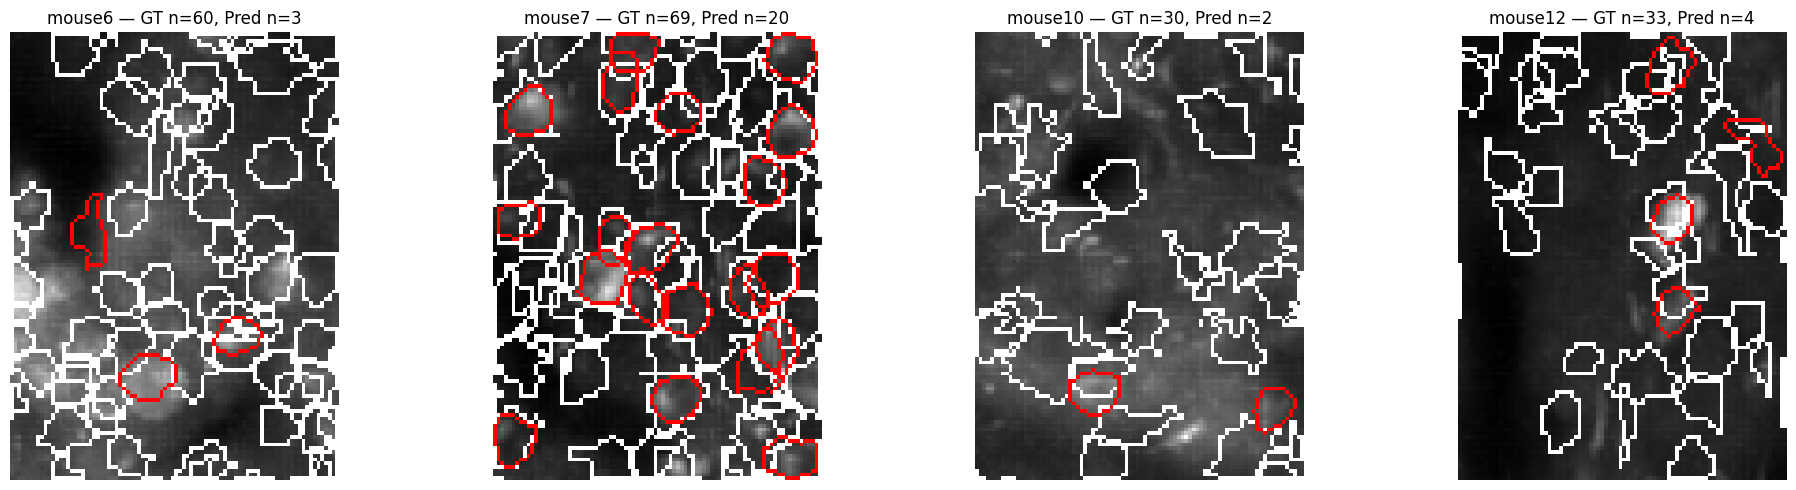

✓ Saved combined figure: /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_scaled/output_line3_scaled/vis/all_videos_gt_pred_overlay.png


In [11]:
# === Overlay predicted (red) + GT (white) for all videos in one figure ===
import math
import matplotlib.pyplot as plt

exp_set = ACTIVE_EXP_SET
dir_video = DATAFOLDER_SETS[exp_set]
list_ids = EXP_ID_SETS[exp_set]
parent = os.path.join(dir_video, OUTPUT_FOLDER[exp_set])
dir_output = os.path.join(parent, 'output_masks')
dir_vis = os.path.join(parent, 'vis')
os.makedirs(dir_vis, exist_ok=True)

# Collect overlays
images = []
titles = []

for vid in list_ids:
    video_path = os.path.join(dir_video, f'{vid}.h5')
    out_mat = os.path.join(dir_output, f'Output_Masks_{vid}.mat')
    gt_sparse = os.path.join(dir_video, 'GT Masks', f'FinalMasks_{vid}_sparse.mat')

    if not os.path.exists(video_path) or not os.path.exists(out_mat):
        print(f'Skipping {vid}: missing inputs')
        continue

    max_img = load_max_projection(video_path)
    Lx, Ly = max_img.shape
    base = (max_img * 255).astype(np.uint8)
    base_rgb = np.stack([base, base, base], axis=-1)

    masks_pred = load_pred_masks(out_mat, (Lx, Ly))
    n_pred = masks_pred.shape[0]

    gt_masks = None
    n_gt = 0
    if os.path.exists(gt_sparse):
        try:
            gt_masks = load_gt_masks_list(gt_sparse, (Lx, Ly))
            n_gt = gt_masks.shape[0]
        except Exception as e:
            print(f'! GT load warning for {vid}: {e}')

    # Draw GT then Pred on the same canvas
    img = draw_contours_for_masks(base_rgb, gt_masks if gt_masks is not None else np.zeros((0, Lx, Ly), bool), (255, 255, 255), 1)
    img = draw_contours_for_masks(img, masks_pred, (255, 0, 0), 1)

    images.append(img)
    titles.append(f'{vid} — GT n={n_gt}, Pred n={n_pred}')

    # Save per-video overlay
    cv2.imwrite(os.path.join(dir_vis, f'{vid}_gt_pred_overlay.png'), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

# Plot all in one figure
n = len(images)
if n == 0:
    print('No overlays to display.')
else:
    cols = min(4, n)
    rows = math.ceil(n / cols)
    plt.figure(figsize=(5*cols, 5*rows))
    for i, (img, title) in enumerate(zip(images, titles), start=1):
        plt.subplot(rows, cols, i)
        plt.title(title)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    combined_path = os.path.join(dir_vis, 'all_videos_gt_pred_overlay.png')
    plt.savefig(combined_path, dpi=200, bbox_inches='tight')
    plt.show()
    print(f'✓ Saved combined figure: {combined_path}')

In [5]:
## 1. Analyze Demo Data (YST datasets)
# Function to find dataset in HDF5 file
def find_dataset(h5_file):
    """Find the main dataset in HDF5 file"""
    if 'mov' in h5_file:
        return 'mov'
    elif 'data' in h5_file:
        return 'data'
    else:
        # Return the first dataset that's not a group
        for key in h5_file.keys():
            if isinstance(h5_file[key], h5py.Dataset):
                return key
    return None

# Function to load video data and get max frame
def load_video_data(file_path):
    """Load video data and return max frame, shape, and metadata"""
    with h5py.File(file_path, 'r') as f:
        dname = find_dataset(f)
        if dname is None:
            raise ValueError(f"No dataset found in {file_path}")
        ds = f[dname]
        video_data = ds[:]  # Load all data
        max_frame = np.max(video_data, axis=0)  # Max projection across time
        shape = video_data.shape  # (T, H, W)
        dtype = video_data.dtype
    return max_frame, shape, dtype

print("Helper functions defined!")


Helper functions defined!


In [6]:
# Analyze demo/data (YST datasets)
demo_set = 'data'
demo_folder = DATAFOLDER_SETS[demo_set]
demo_video_ids = EXP_ID_SETS[demo_set]
demo_mag = MAG[demo_set]
demo_rate = RATE_HZ[demo_set]
demo_um_per_px = 0.785 / demo_mag  # Convert MAG to µm/px

print(f"=== DEMO DATA ANALYSIS ===")
print(f"Dataset: {demo_set}")
print(f"Folder: {demo_folder}")
print(f"Video IDs: {demo_video_ids}")
print(f"Pixel size: {demo_um_per_px:.3f} µm/px (MAG={demo_mag:.3f})")
print(f"Acquisition rate: {demo_rate} Hz")
print()

# Load and analyze each demo video
demo_info = []
demo_max_frames = []

for vid_id in demo_video_ids:
    file_path = os.path.join(demo_folder, f"{vid_id}.h5")
    if not os.path.exists(file_path):
        print(f"Warning: {vid_id}.h5 not found at {file_path}")
        continue
    
    try:
        max_frame, shape, dtype = load_video_data(file_path)
        T, H, W = shape
        print(f"{vid_id}: frames={T}, size={H}×{W} px, dtype={dtype}")
        demo_info.append((vid_id, T, H, W, dtype))
        demo_max_frames.append((vid_id, max_frame))
    except Exception as e:
        print(f"Error loading {vid_id}: {e}")

print(f"\nSuccessfully loaded {len(demo_info)} demo videos")


=== DEMO DATA ANALYSIS ===
Dataset: data
Folder: /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/data
Video IDs: ['YST_part11', 'YST_part12', 'YST_part21', 'YST_part22']
Pixel size: 1.047 µm/px (MAG=0.750)
Acquisition rate: 10 Hz

YST_part11: frames=3000, size=120×88 px, dtype=uint16
YST_part12: frames=3000, size=120×88 px, dtype=uint16
YST_part21: frames=3000, size=120×88 px, dtype=uint16
YST_part22: frames=3000, size=120×88 px, dtype=uint16

Successfully loaded 4 demo videos


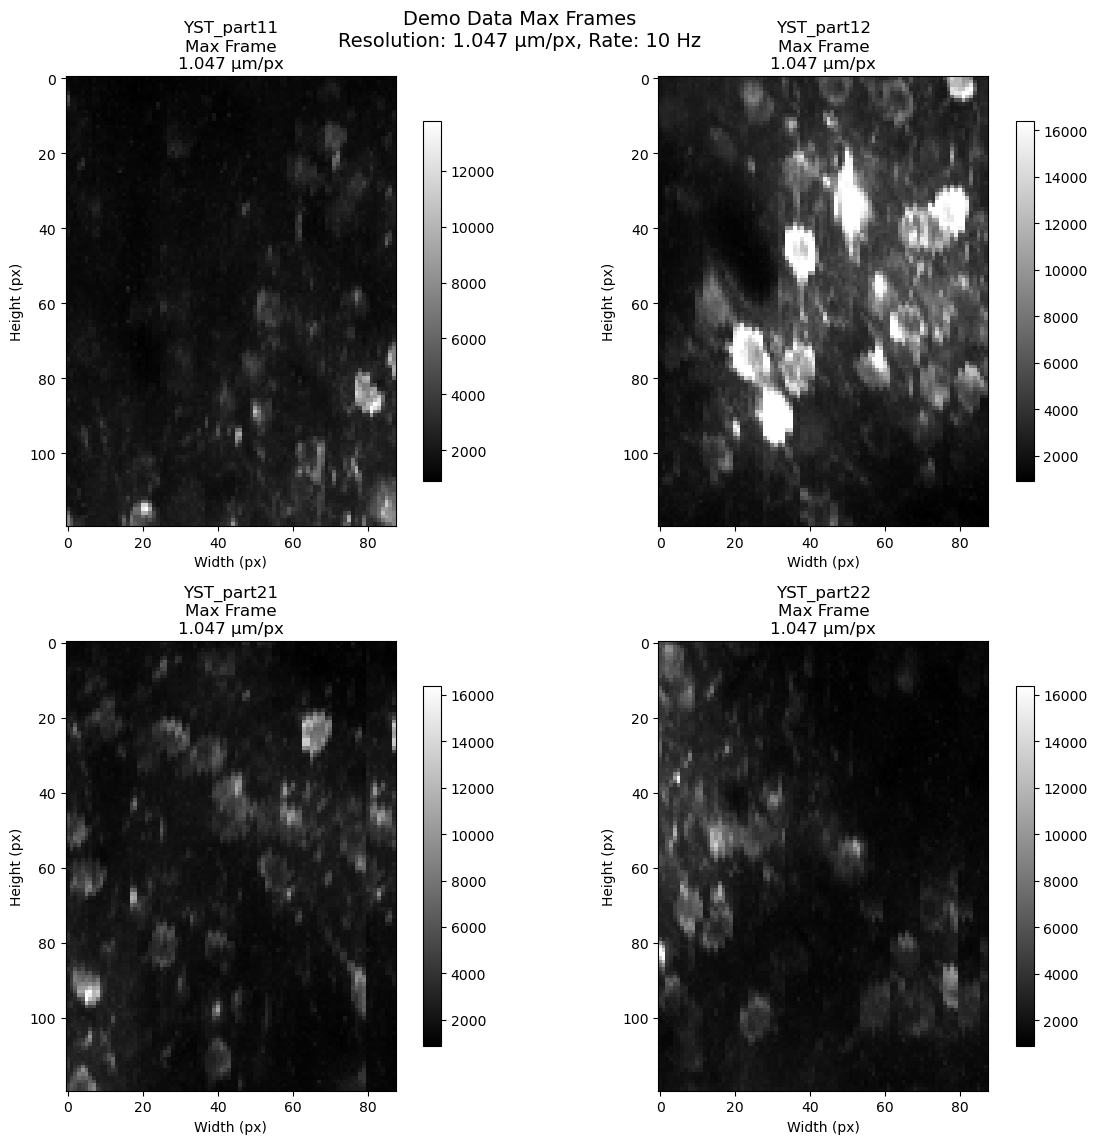

In [7]:
# Plot max frames for demo data
if demo_max_frames:
    n_videos = len(demo_max_frames)
    cols = min(2, n_videos)
    rows = (n_videos + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6*rows))
    if n_videos == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, (vid_id, max_frame) in enumerate(demo_max_frames):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        
        im = ax.imshow(max_frame, cmap='gray', aspect='equal')
        ax.set_title(f"{vid_id}\nMax Frame\n{demo_um_per_px:.3f} µm/px")
        ax.set_xlabel("Width (px)")
        ax.set_ylabel("Height (px)")
        plt.colorbar(im, ax=ax, shrink=0.8)
    
    # Hide unused subplots
    for i in range(n_videos, rows * cols):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.axis('off')
    
    plt.suptitle(f"Demo Data Max Frames\nResolution: {demo_um_per_px:.3f} µm/px, Rate: {demo_rate} Hz", 
                 fontsize=14, y=0.95)
    plt.tight_layout()
    plt.show()
else:
    print("No demo videos to plot")


## 2. Analyze Line3 Dataset


In [8]:
# Analyze line3_dataset
line3_set = 'line3_dataset'
line3_folder = DATAFOLDER_SETS[line3_set]
line3_video_ids = EXP_ID_SETS[line3_set]
line3_mag = MAG[line3_set]
line3_rate = RATE_HZ[line3_set]
line3_um_per_px = 0.785 / line3_mag  # Convert MAG to µm/px

print(f"=== LINE3 DATASET ANALYSIS ===")
print(f"Dataset: {line3_set}")
print(f"Folder: {line3_folder}")
print(f"Video IDs: {line3_video_ids}")
print(f"Pixel size: {line3_um_per_px:.3f} µm/px (MAG={line3_mag:.3f})")
print(f"Acquisition rate: {line3_rate} Hz")
print()

# Load and analyze each line3 video
line3_info = []
line3_max_frames = []

for vid_id in line3_video_ids:
    file_path = os.path.join(line3_folder, f"{vid_id}.h5")
    if not os.path.exists(file_path):
        print(f"Warning: {vid_id}.h5 not found at {file_path}")
        continue
    
    try:
        max_frame, shape, dtype = load_video_data(file_path)
        T, H, W = shape
        print(f"{vid_id}: frames={T}, size={H}×{W} px, dtype={dtype}")
        line3_info.append((vid_id, T, H, W, dtype))
        line3_max_frames.append((vid_id, max_frame))
    except Exception as e:
        print(f"Error loading {vid_id}: {e}")

print(f"\nSuccessfully loaded {len(line3_info)} line3 videos")


=== LINE3 DATASET ANALYSIS ===
Dataset: line3_dataset
Folder: /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_dataset
Video IDs: ['mouse6', 'mouse7', 'mouse10', 'mouse12']
Pixel size: 1.967 µm/px (MAG=0.399)
Acquisition rate: 3.56 Hz

mouse6: frames=1600, size=256×256 px, dtype=uint16
mouse7: frames=1600, size=256×256 px, dtype=uint16
mouse10: frames=1600, size=256×256 px, dtype=uint16
mouse12: frames=1600, size=256×256 px, dtype=uint16

Successfully loaded 4 line3 videos


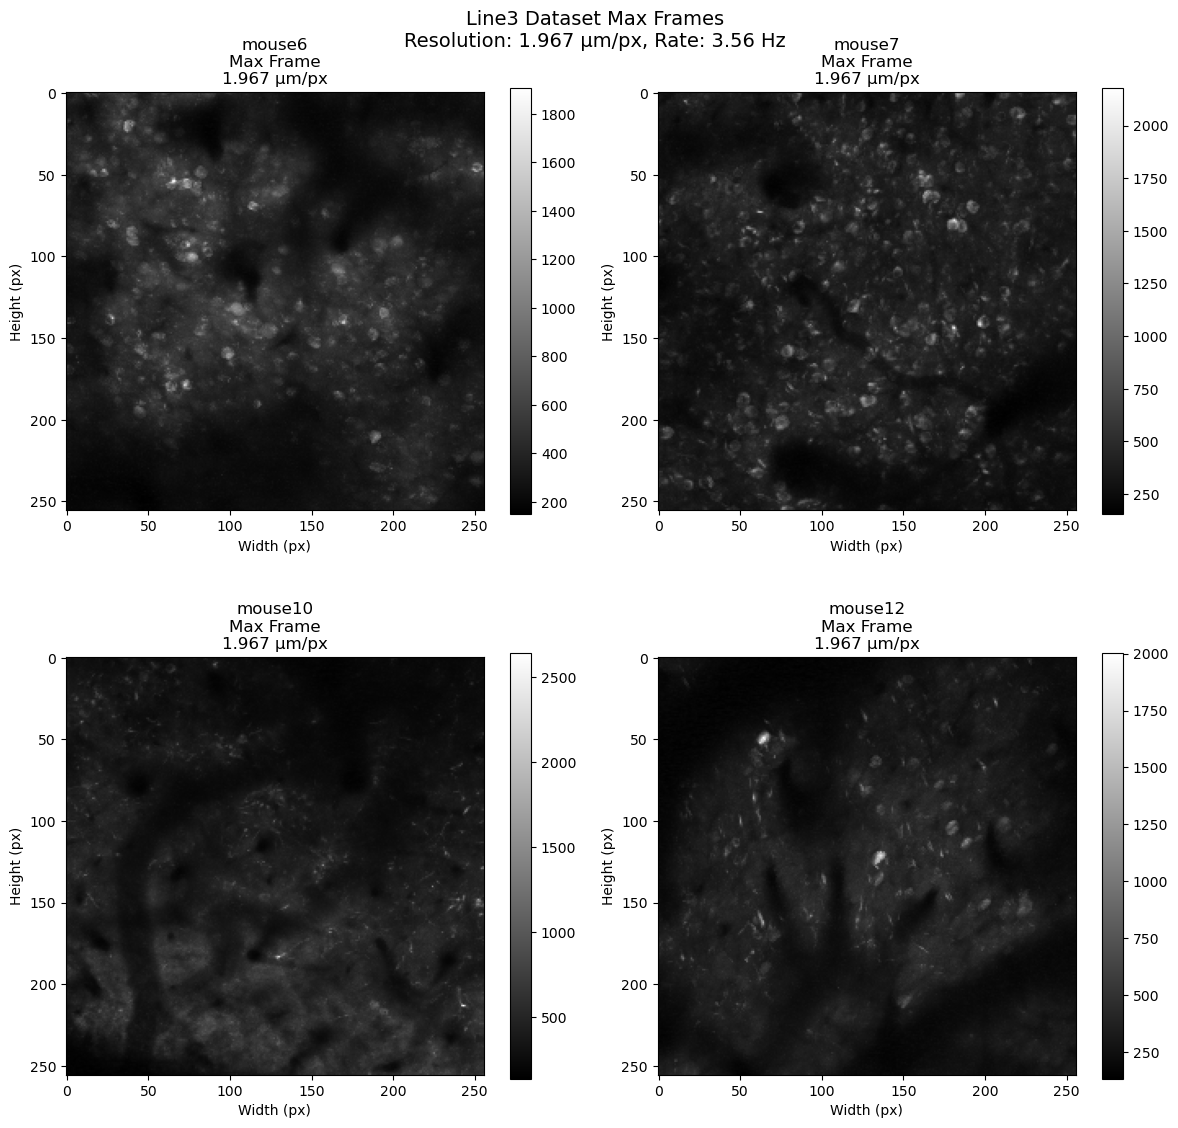

In [9]:
# Plot max frames for line3 data
if line3_max_frames:
    n_videos = len(line3_max_frames)
    cols = min(2, n_videos)
    rows = (n_videos + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6*rows))
    if n_videos == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, (vid_id, max_frame) in enumerate(line3_max_frames):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        
        im = ax.imshow(max_frame, cmap='gray', aspect='equal')
        ax.set_title(f"{vid_id}\nMax Frame\n{line3_um_per_px:.3f} µm/px")
        ax.set_xlabel("Width (px)")
        ax.set_ylabel("Height (px)")
        plt.colorbar(im, ax=ax, shrink=0.8)
    
    # Hide unused subplots
    for i in range(n_videos, rows * cols):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.axis('off')
    
    plt.suptitle(f"Line3 Dataset Max Frames\nResolution: {line3_um_per_px:.3f} µm/px, Rate: {line3_rate} Hz", 
                 fontsize=14, y=0.95)
    plt.tight_layout()
    plt.show()
else:
    print("No line3 videos to plot")


## 3. Scale Line3 Dataset to Match Demo Data Resolution and Dimensions


In [10]:
# Calculate scaling factors
if demo_info and line3_info:
    # Get target dimensions from demo data (assuming all demo videos have same dimensions)
    demo_T, demo_H, demo_W = demo_info[0][1:4]  # Get dimensions from first demo video
    
    # Calculate spatial scaling factor based on resolution difference
    spatial_scale_factor = line3_um_per_px / demo_um_per_px
    
    print(f"=== SCALING CALCULATIONS ===")
    print(f"Demo data resolution: {demo_um_per_px:.3f} µm/px")
    print(f"Line3 data resolution: {line3_um_per_px:.3f} µm/px")
    print(f"Spatial scale factor: {spatial_scale_factor:.3f}")
    print(f"Target dimensions: {demo_T}×{demo_H}×{demo_W} (T×H×W)")
    print()
    
    # Calculate target dimensions for line3 data
    line3_T, line3_H, line3_W = line3_info[0][1:4]  # Get dimensions from first line3 video
    target_H = int(line3_H * spatial_scale_factor)
    target_W = int(line3_W * spatial_scale_factor)
    
    print(f"Line3 original dimensions: {line3_T}×{line3_H}×{line3_W} (T×H×W)")
    print(f"Line3 target dimensions: {line3_T}×{target_H}×{target_W} (T×H×W)")
    print(f"Scale factors: H={spatial_scale_factor:.3f}, W={spatial_scale_factor:.3f}")
else:
    print("Error: Need both demo and line3 data to calculate scaling factors")


=== SCALING CALCULATIONS ===
Demo data resolution: 1.047 µm/px
Line3 data resolution: 1.967 µm/px
Spatial scale factor: 1.880
Target dimensions: 3000×120×88 (T×H×W)

Line3 original dimensions: 1600×256×256 (T×H×W)
Line3 target dimensions: 1600×481×481 (T×H×W)
Scale factors: H=1.880, W=1.880


In [11]:
# Function to scale video data
def scale_video_data(video_data, scale_factor):
    """Scale video data using scipy.ndimage.zoom"""
    # video_data shape: (T, H, W)
    # scale_factor: spatial scaling factor
    zoom_factors = (1.0, scale_factor, scale_factor)  # No temporal scaling
    scaled_data = zoom(video_data, zoom_factors, order=1, mode='nearest')  # Linear interpolation
    return scaled_data

# Create output directory for scaled data
scaled_folder = DATAFOLDER_SETS['line3_scaled']
os.makedirs(scaled_folder, exist_ok=True)
print(f"Created output directory: {scaled_folder}")

# Scale each line3 video
scaled_info = []
scaled_max_frames = []

for vid_id, original_T, original_H, original_W, dtype in line3_info:
    print(f"\nScaling {vid_id}...")
    
    # Load original data
    original_path = os.path.join(line3_folder, f"{vid_id}.h5")
    with h5py.File(original_path, 'r') as f:
        dname = find_dataset(f)
        original_data = f[dname][:]
    
    # Scale the data
    scaled_data = scale_video_data(original_data, spatial_scale_factor)
    scaled_T, scaled_H, scaled_W = scaled_data.shape
    
    # Save scaled data
    scaled_path = os.path.join(scaled_folder, f"{vid_id}.h5")
    with h5py.File(scaled_path, 'w') as f:
        f.create_dataset('mov', data=scaled_data, compression='gzip')
    
    # Calculate max frame
    scaled_max_frame = np.max(scaled_data, axis=0)
    
    print(f"  Original: {original_T}×{original_H}×{original_W}")
    print(f"  Scaled:   {scaled_T}×{scaled_H}×{scaled_W}")
    print(f"  Saved to: {scaled_path}")
    
    scaled_info.append((vid_id, scaled_T, scaled_H, scaled_W, dtype))
    scaled_max_frames.append((vid_id, scaled_max_frame))

print(f"\nSuccessfully scaled {len(scaled_info)} videos")


Created output directory: /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_scaled

Scaling mouse6...
  Original: 1600×256×256
  Scaled:   1600×481×481
  Saved to: /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_scaled/mouse6.h5

Scaling mouse7...
  Original: 1600×256×256
  Scaled:   1600×481×481
  Saved to: /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_scaled/mouse7.h5

Scaling mouse10...
  Original: 1600×256×256
  Scaled:   1600×481×481
  Saved to: /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_scaled/mouse10.h5

Scaling mouse12...
  Original: 1600×256×256
  Scaled:   1600×481×481
  Saved to: /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_scaled/mouse12.h5

Successfully scaled 4 videos


## 4. Plot Comparison: Before and After Scaling


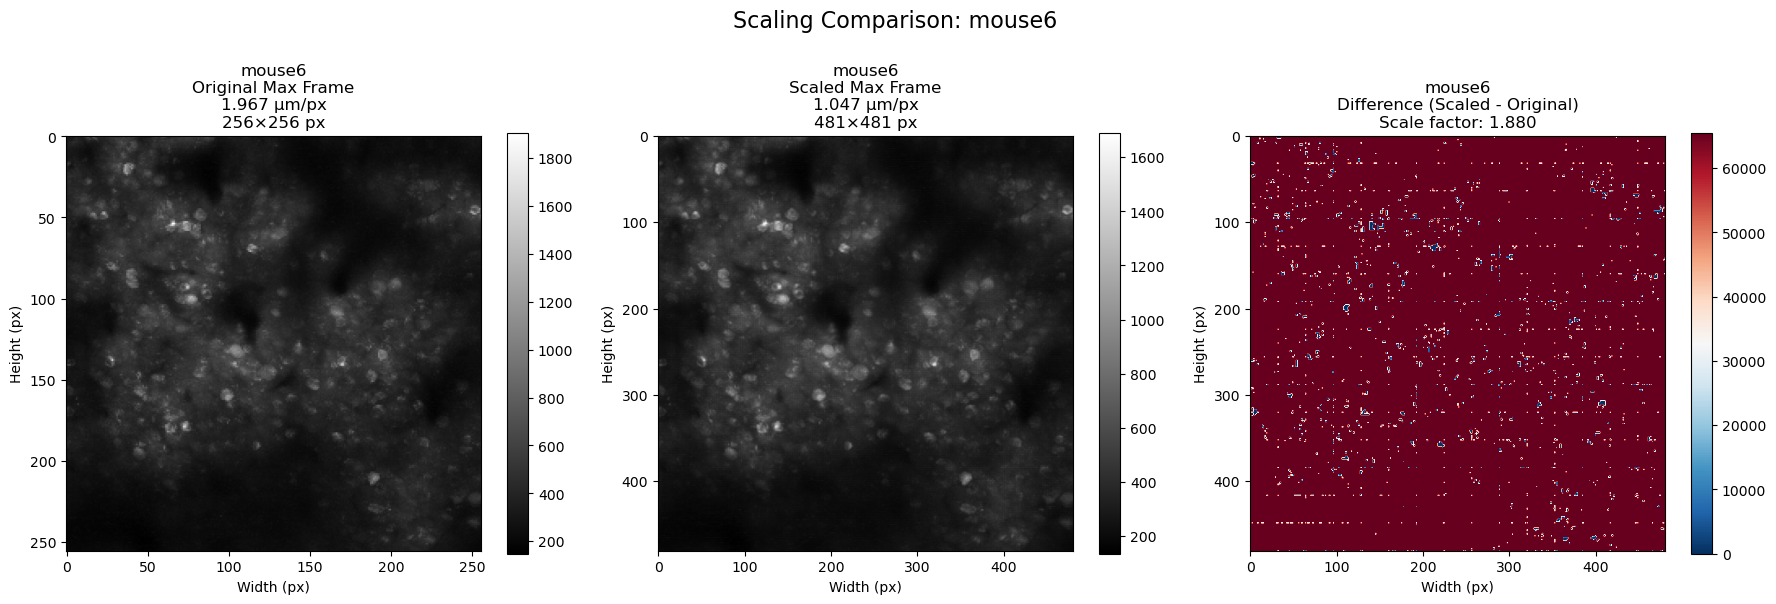


Scaling Statistics for mouse6:
  Original resolution: 1.967 µm/px
  Scaled resolution:   1.047 µm/px
  Scale factor:        1.880
  Original dimensions: 256×256 px
  Scaled dimensions:   481×481 px
  Difference range:    [0.00, 65535.00]


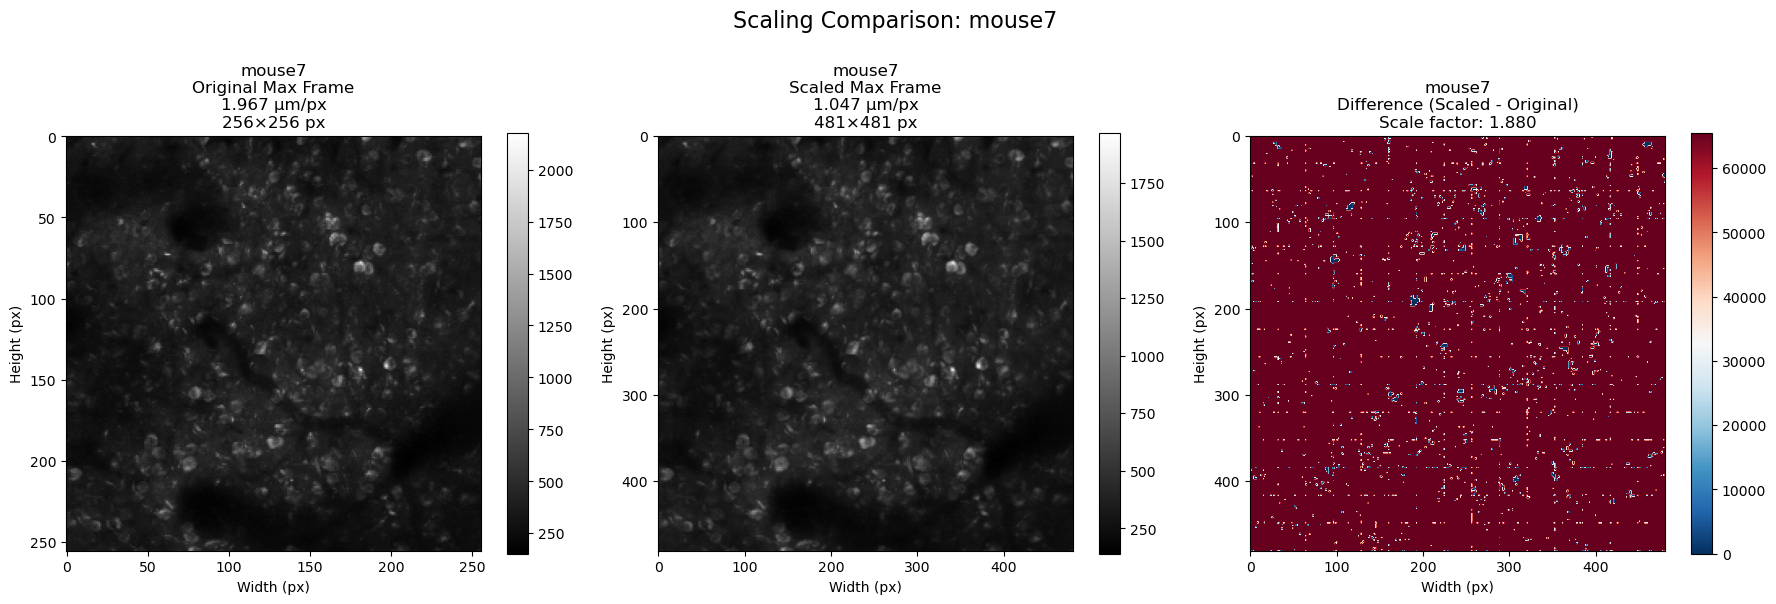


Scaling Statistics for mouse7:
  Original resolution: 1.967 µm/px
  Scaled resolution:   1.047 µm/px
  Scale factor:        1.880
  Original dimensions: 256×256 px
  Scaled dimensions:   481×481 px
  Difference range:    [0.00, 65535.00]


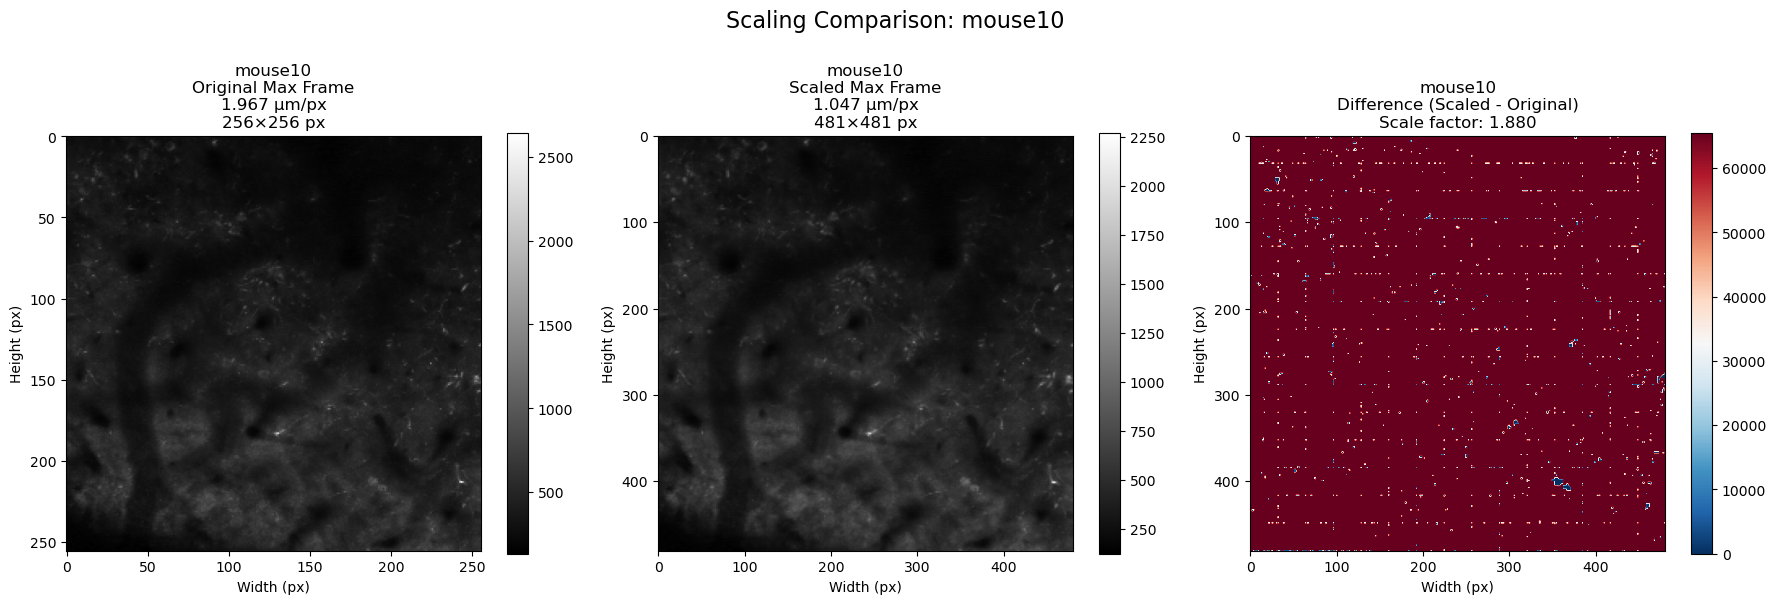


Scaling Statistics for mouse10:
  Original resolution: 1.967 µm/px
  Scaled resolution:   1.047 µm/px
  Scale factor:        1.880
  Original dimensions: 256×256 px
  Scaled dimensions:   481×481 px
  Difference range:    [0.00, 65535.00]


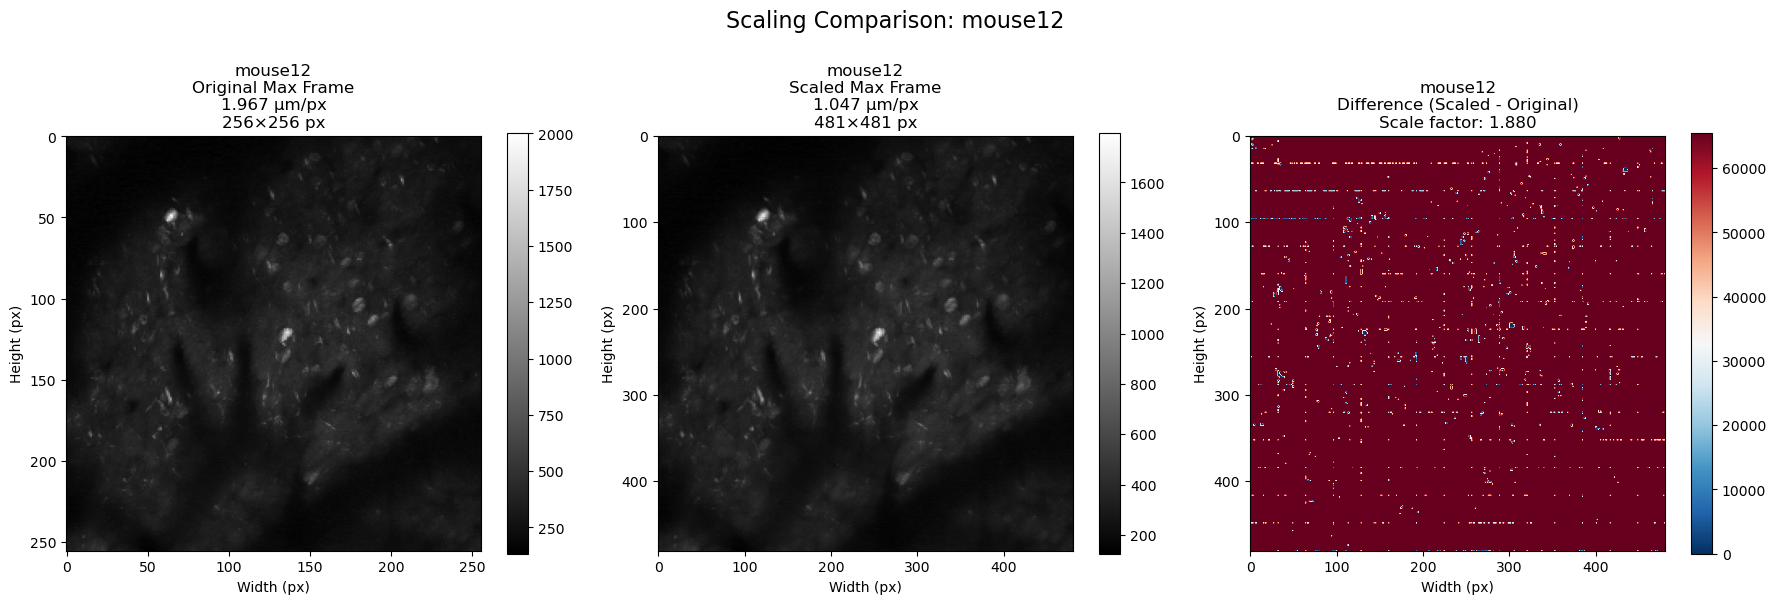


Scaling Statistics for mouse12:
  Original resolution: 1.967 µm/px
  Scaled resolution:   1.047 µm/px
  Scale factor:        1.880
  Original dimensions: 256×256 px
  Scaled dimensions:   481×481 px
  Difference range:    [0.00, 65535.00]


In [12]:
# Plot comparison for each video
if line3_max_frames and scaled_max_frames:
    n_videos = len(line3_max_frames)
    
    for i, (vid_id, original_max_frame) in enumerate(line3_max_frames):
        scaled_max_frame = scaled_max_frames[i][1]  # Get corresponding scaled max frame
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Original max frame
        im1 = axes[0].imshow(original_max_frame, cmap='gray', aspect='equal')
        axes[0].set_title(f"{vid_id}\nOriginal Max Frame\n{line3_um_per_px:.3f} µm/px\n{original_max_frame.shape[0]}×{original_max_frame.shape[1]} px")
        axes[0].set_xlabel("Width (px)")
        axes[0].set_ylabel("Height (px)")
        plt.colorbar(im1, ax=axes[0], shrink=0.8)
        
        # Scaled max frame
        im2 = axes[1].imshow(scaled_max_frame, cmap='gray', aspect='equal')
        axes[1].set_title(f"{vid_id}\nScaled Max Frame\n{demo_um_per_px:.3f} µm/px\n{scaled_max_frame.shape[0]}×{scaled_max_frame.shape[1]} px")
        axes[1].set_xlabel("Width (px)")
        axes[1].set_ylabel("Height (px)")
        plt.colorbar(im2, ax=axes[1], shrink=0.8)
        
        # Difference (scaled - original resized)
        # Resize original to match scaled dimensions for comparison
        from scipy.ndimage import zoom
        original_resized = zoom(original_max_frame, spatial_scale_factor, order=1)
        diff = scaled_max_frame - original_resized
        
        im3 = axes[2].imshow(diff, cmap='RdBu_r', aspect='equal')
        axes[2].set_title(f"{vid_id}\nDifference (Scaled - Original)\nScale factor: {spatial_scale_factor:.3f}")
        axes[2].set_xlabel("Width (px)")
        axes[2].set_ylabel("Height (px)")
        plt.colorbar(im3, ax=axes[2], shrink=0.8)
        
        plt.suptitle(f"Scaling Comparison: {vid_id}", fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()
        
        # Print scaling statistics
        print(f"\nScaling Statistics for {vid_id}:")
        print(f"  Original resolution: {line3_um_per_px:.3f} µm/px")
        print(f"  Scaled resolution:   {demo_um_per_px:.3f} µm/px")
        print(f"  Scale factor:        {spatial_scale_factor:.3f}")
        print(f"  Original dimensions: {original_max_frame.shape[0]}×{original_max_frame.shape[1]} px")
        print(f"  Scaled dimensions:   {scaled_max_frame.shape[0]}×{scaled_max_frame.shape[1]} px")
        print(f"  Difference range:    [{diff.min():.2f}, {diff.max():.2f}]")
else:
    print("No data available for comparison")


## Summary


In [13]:
# Print summary of all datasets
print("=== SUMMARY ===")
print(f"\nDemo Data ({demo_set}):")
print(f"  Resolution: {demo_um_per_px:.3f} µm/px (MAG={demo_mag:.3f})")
print(f"  Rate: {demo_rate} Hz")
print(f"  Videos: {len(demo_info)}")
if demo_info:
    demo_T, demo_H, demo_W = demo_info[0][1:4]
    print(f"  Dimensions: {demo_T}×{demo_H}×{demo_W} (T×H×W)")

print(f"\nLine3 Original ({line3_set}):")
print(f"  Resolution: {line3_um_per_px:.3f} µm/px (MAG={line3_mag:.3f})")
print(f"  Rate: {line3_rate} Hz")
print(f"  Videos: {len(line3_info)}")
if line3_info:
    line3_T, line3_H, line3_W = line3_info[0][1:4]
    print(f"  Dimensions: {line3_T}×{line3_H}×{line3_W} (T×H×W)")

print(f"\nLine3 Scaled (line3_scaled):")
print(f"  Resolution: {demo_um_per_px:.3f} µm/px (matched to demo)")
print(f"  Rate: {line3_rate} Hz (unchanged)")
print(f"  Videos: {len(scaled_info)}")
if scaled_info:
    scaled_T, scaled_H, scaled_W = scaled_info[0][1:4]
    print(f"  Dimensions: {scaled_T}×{scaled_H}×{scaled_W} (T×H×W)")

print(f"\nScaling Factor: {spatial_scale_factor:.3f}")
print(f"Output Directory: {scaled_folder}")
print("\n✓ Analysis and scaling complete!")


=== SUMMARY ===

Demo Data (data):
  Resolution: 1.047 µm/px (MAG=0.750)
  Rate: 10 Hz
  Videos: 4
  Dimensions: 3000×120×88 (T×H×W)

Line3 Original (line3_dataset):
  Resolution: 1.967 µm/px (MAG=0.399)
  Rate: 3.56 Hz
  Videos: 4
  Dimensions: 1600×256×256 (T×H×W)

Line3 Scaled (line3_scaled):
  Resolution: 1.047 µm/px (matched to demo)
  Rate: 3.56 Hz (unchanged)
  Videos: 4
  Dimensions: 1600×481×481 (T×H×W)

Scaling Factor: 1.880
Output Directory: /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_scaled

✓ Analysis and scaling complete!


## 5. Center-crop scaled videos to 120×88 (match demo)


In [14]:
# Cropping utilities and config
TARGET_H, TARGET_W = 120, 88  # demo/data size (Ly, Lx)


def center_crop_2d(img: np.ndarray, target_h: int, target_w: int) -> np.ndarray:
    """Center-crop a 2D array to (target_h, target_w). If smaller, pad with zeros."""
    h, w = img.shape
    dh = max(0, target_h - h)
    dw = max(0, target_w - w)
    # Pad if needed (symmetric)
    if dh > 0 or dw > 0:
        pad_top = dh // 2
        pad_bottom = dh - pad_top
        pad_left = dw // 2
        pad_right = dw - pad_left
        img = np.pad(img, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant')
        h, w = img.shape
    # Now crop center
    y0 = (h - target_h) // 2
    x0 = (w - target_w) // 2
    return img[y0:y0+target_h, x0:x0+target_w]


def center_crop_video(video: np.ndarray, target_h: int, target_w: int) -> np.ndarray:
    """Center-crop a 3D video (T, H, W) to (T, target_h, target_w)."""
    T, H, W = video.shape
    cropped = np.empty((T, target_h, target_w), dtype=video.dtype)
    for t in range(T):
        cropped[t] = center_crop_2d(video[t], target_h, target_w)
    return cropped

print(f"Cropping ready: target size {TARGET_H}×{TARGET_W}")


Cropping ready: target size 120×88


In [15]:
# Apply center-crop to scaled videos and save (overwrite in line3_scaled)
cropped_folder = DATAFOLDER_SETS['line3_scaled']
os.makedirs(cropped_folder, exist_ok=True)
print(f"Output for cropped videos (overwrite): {cropped_folder}")

cropped_info = []
cropped_max_frames = []

for vid_id, scaled_T, scaled_H, scaled_W, dtype in scaled_info:
    scaled_path = os.path.join(DATAFOLDER_SETS['line3_scaled'], f"{vid_id}.h5")
    if not os.path.exists(scaled_path):
        print(f"Skipping {vid_id}: scaled file missing at {scaled_path}")
        continue

    print(f"\nCropping {vid_id} from {scaled_H}×{scaled_W} -> {TARGET_H}×{TARGET_W}")
    with h5py.File(scaled_path, 'r') as f:
        dset_name = 'mov' if 'mov' in f else list(f.keys())[0]
        scaled_video = f[dset_name][:]

    cropped_video = center_crop_video(scaled_video, TARGET_H, TARGET_W)
    cropped_T, cropped_H, cropped_W = cropped_video.shape

    # Overwrite the existing scaled file with cropped content
    with h5py.File(scaled_path, 'w') as f:
        f.create_dataset('mov', data=cropped_video, compression='gzip')

    cropped_max = np.max(cropped_video, axis=0)
    cropped_info.append((vid_id, cropped_T, cropped_H, cropped_W, dtype))
    cropped_max_frames.append((vid_id, cropped_max))

    print(f"  Saved (overwritten): {scaled_path}")

print(f"\n✓ Cropped {len(cropped_info)} videos to {TARGET_H}×{TARGET_W} in {cropped_folder}")


Output for cropped videos (overwrite): /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_scaled

Cropping mouse6 from 481×481 -> 120×88
  Saved (overwritten): /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_scaled/mouse6.h5

Cropping mouse7 from 481×481 -> 120×88
  Saved (overwritten): /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_scaled/mouse7.h5

Cropping mouse10 from 481×481 -> 120×88
  Saved (overwritten): /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_scaled/mouse10.h5

Cropping mouse12 from 481×481 -> 120×88
  Saved (overwritten): /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_scaled/mouse12.h5

✓ Cropped 4 videos to 120×88 in /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_scaled


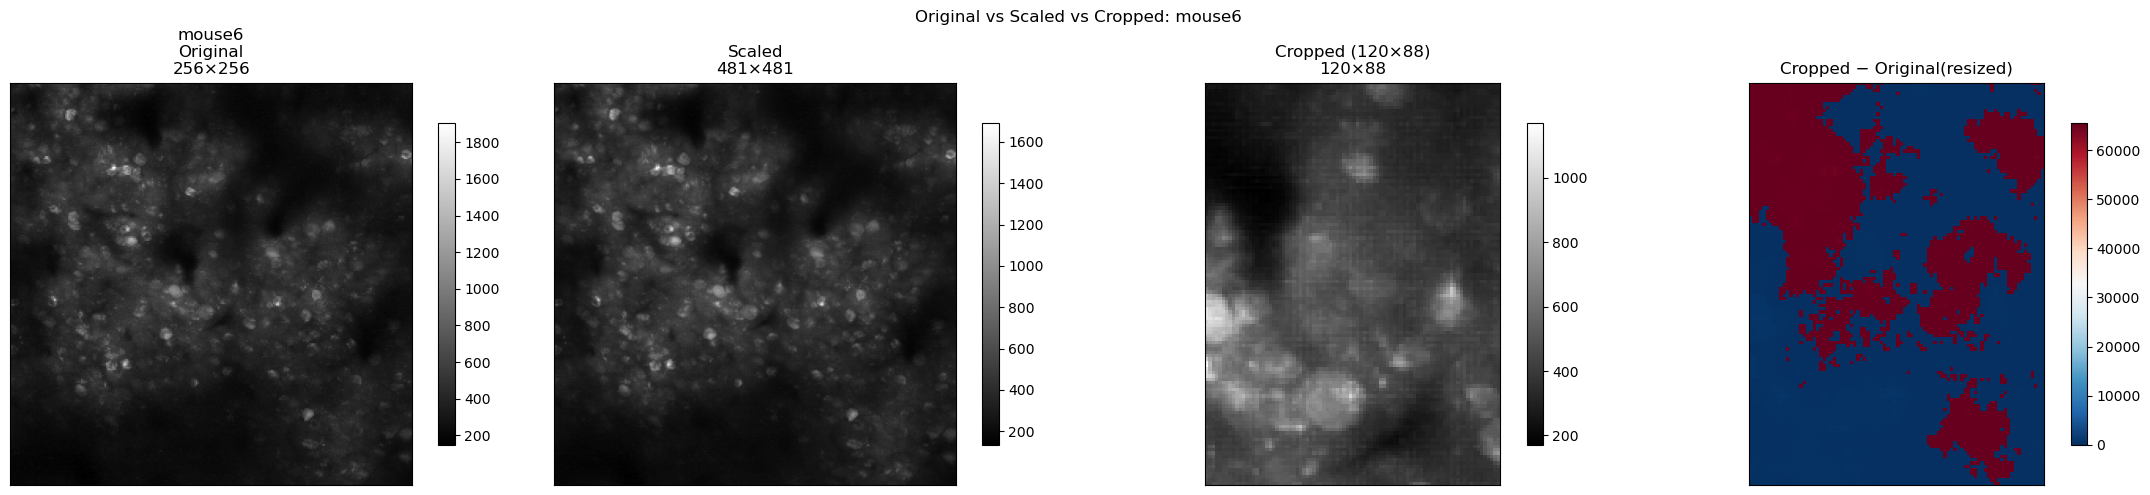

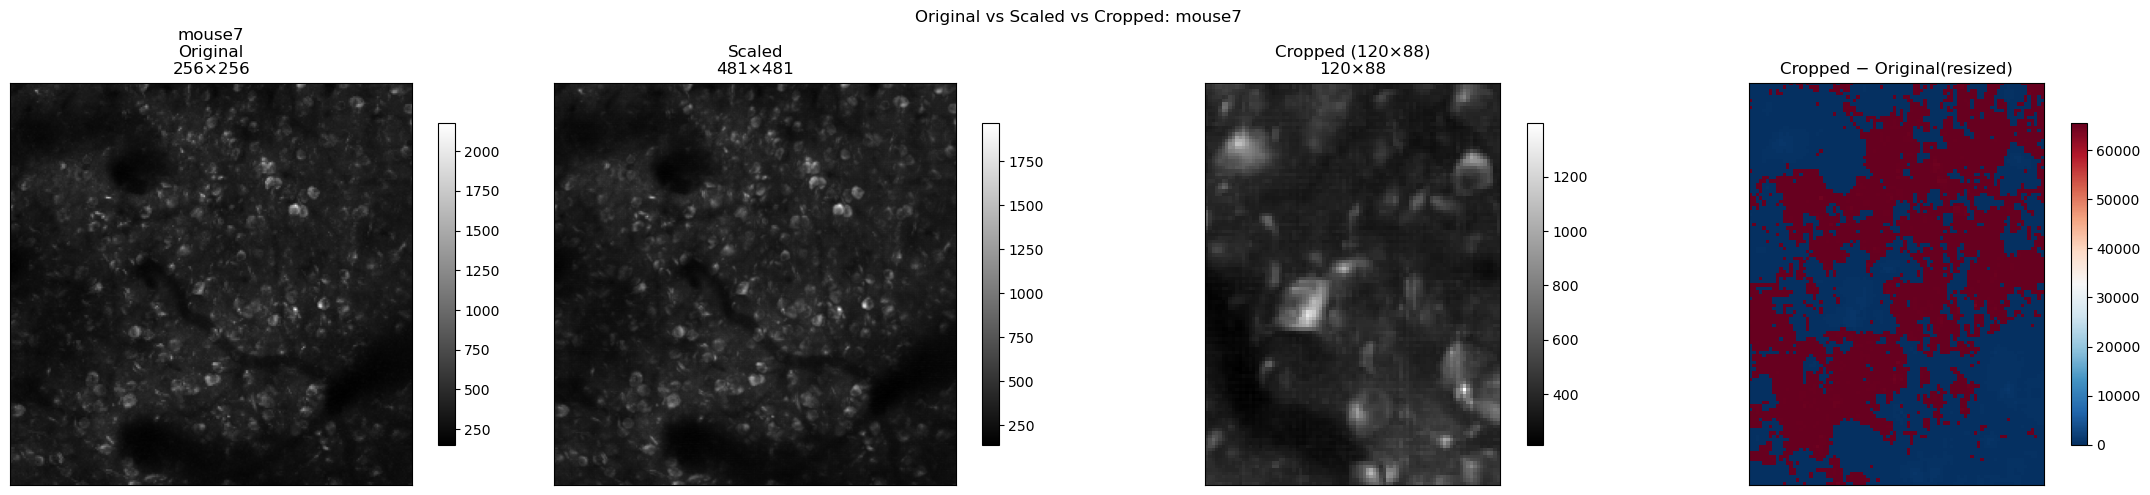

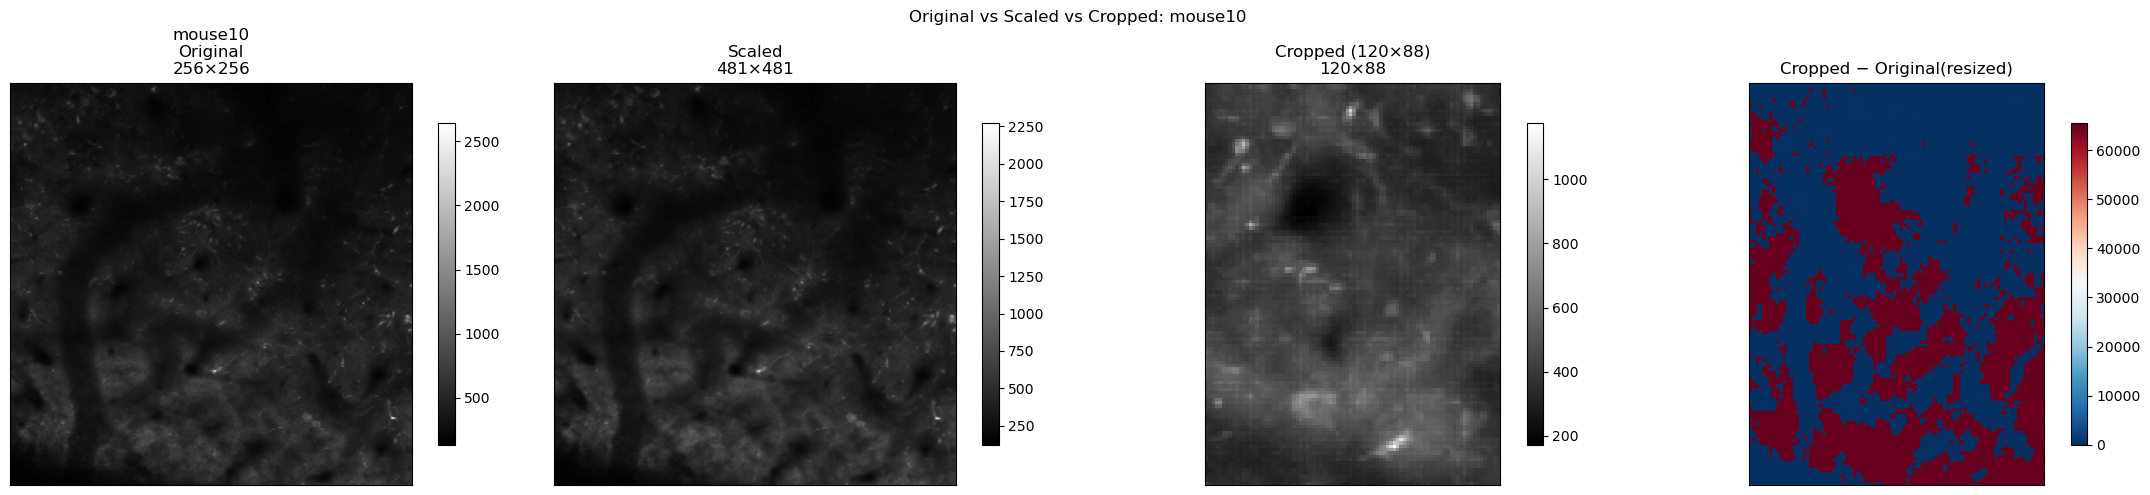

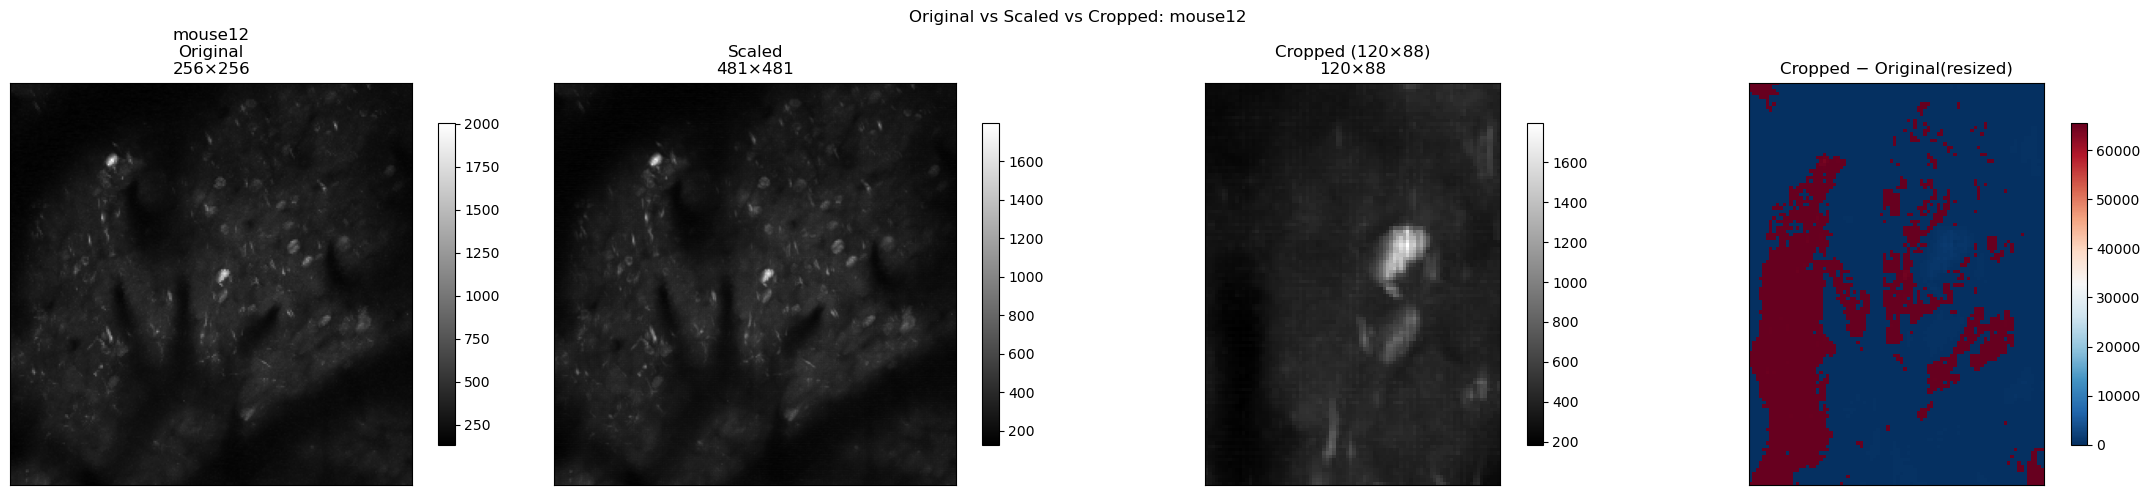

In [16]:
# Extend comparison with cropped frames
if line3_max_frames and scaled_max_frames and cropped_max_frames:
    for i, (vid_id, original_max) in enumerate(line3_max_frames):
        scaled_max = scaled_max_frames[i][1]
        cropped_max = cropped_max_frames[i][1]

        fig, axes = plt.subplots(1, 4, figsize=(22, 5))

        im0 = axes[0].imshow(original_max, cmap='gray'); axes[0].set_title(f"{vid_id}\nOriginal\n{original_max.shape[0]}×{original_max.shape[1]}")
        plt.colorbar(im0, ax=axes[0], shrink=0.8)

        im1 = axes[1].imshow(scaled_max, cmap='gray'); axes[1].set_title(f"Scaled\n{scaled_max.shape[0]}×{scaled_max.shape[1]}")
        plt.colorbar(im1, ax=axes[1], shrink=0.8)

        im2 = axes[2].imshow(cropped_max, cmap='gray'); axes[2].set_title(f"Cropped (120×88)\n{cropped_max.shape[0]}×{cropped_max.shape[1]}")
        plt.colorbar(im2, ax=axes[2], shrink=0.8)

        # Difference between cropped and original resized to cropped size
        from scipy.ndimage import zoom
        scale_y = cropped_max.shape[0] / original_max.shape[0]
        scale_x = cropped_max.shape[1] / original_max.shape[1]
        original_resized_to_cropped = zoom(original_max, (scale_y, scale_x), order=1)
        diff = cropped_max - original_resized_to_cropped
        im3 = axes[3].imshow(diff, cmap='RdBu_r'); axes[3].set_title("Cropped − Original(resized)")
        plt.colorbar(im3, ax=axes[3], shrink=0.8)

        for ax in axes: ax.set_xticks([]); ax.set_yticks([])
        plt.suptitle(f"Original vs Scaled vs Cropped: {vid_id}")
        plt.tight_layout(); plt.show()
else:
    print("No sufficient data to plot cropped comparisons")


In [ ]:
## 6. Visualize GT Masks from line3_scaled dataset (120×88)


In [ ]:
# Load and visualize GT masks from line3_scaled dataset
def load_gt_masks(mat_path):
    """Load GT masks from .mat file, handling both HDF5 and v7 formats"""
    try:
        with h5py.File(mat_path, 'r') as f:
            if 'FinalMasks' in f:
                return np.array(f['FinalMasks'])
            if 'GTMasks_2' in f:
                return np.array(f['GTMasks_2'])
    except OSError:
        pass
    
    from scipy.io import loadmat
    md = loadmat(mat_path)
    if 'FinalMasks' in md:
        return np.array(md['FinalMasks'])
    if 'GTMasks_2' in md:
        return np.array(md['GTMasks_2'])
    raise KeyError(f"No 'FinalMasks' or 'GTMasks_2' in {mat_path}")

def count_rois_in_masks(masks):
    """Count the number of unique ROIs in the mask array"""
    if masks is None:
        return 0
    
    if masks.ndim == 3:
        # For 3D masks, check if it's (H, W, N_ROIS) or (N_ROIS, H, W)
        if masks.shape[0] < masks.shape[2]:
            # Shape is (H, W, N_ROIS) - count along last dimension
            return np.sum([np.any(masks[:, :, i]) for i in range(masks.shape[2])])
        else:
            # Shape is (N_ROIS, H, W) - count along first dimension
            return np.sum([np.any(masks[i]) for i in range(masks.shape[0])])
    elif masks.ndim == 2:
        # For 2D masks, count unique non-zero regions
        from scipy.ndimage import label
        labeled, num_features = label(masks > 0)
        return num_features
    else:
        return 0

def create_combined_mask_image(masks):
    """Create a combined visualization of all masks - black background, white masks"""
    if masks is None:
        return None
    
    if masks.ndim == 3:
        # For 3D masks, check if it's (H, W, N_ROIS) or (N_ROIS, H, W)
        if masks.shape[0] < masks.shape[2]:
            # Shape is (H, W, N_ROIS) - combine along last dimension
            combined = np.zeros(masks.shape[:2], dtype=float)
            for i in range(masks.shape[2]):
                if np.any(masks[:, :, i]):
                    # Set to 1 (white) where any mask is present
                    combined = np.logical_or(combined, masks[:, :, i]).astype(float)
        else:
            # Shape is (N_ROIS, H, W) - combine along first dimension
            combined = np.zeros(masks.shape[1:], dtype=float)
            for i in range(masks.shape[0]):
                if np.any(masks[i]):
                    # Set to 1 (white) where any mask is present
                    combined = np.logical_or(combined, masks[i]).astype(float)
        return combined
    elif masks.ndim == 2:
        # For 2D masks, use as is
        return masks.astype(float)
    else:
        return None

# Load GT masks from line3_scaled dataset
scaled_gt_folder = os.path.join(DATAFOLDER_SETS['line3_scaled'], 'GT Masks')
print(f"=== LOADING GT MASKS FROM LINE3_SCALED ===")
print(f"GT folder: {scaled_gt_folder}")

# Load masks for each mouse
scaled_gt_data = {}

for vid_id in line3_video_ids:
    print(f"\n--- Loading {vid_id} GT masks ---")
    
    # Load scaled masks (120x88)
    scaled_path = os.path.join(scaled_gt_folder, f"FinalMasks_{vid_id}.mat")
    if os.path.exists(scaled_path):
        try:
            scaled_masks = load_gt_masks(scaled_path)
            print(f"Scaled masks shape: {scaled_masks.shape}")
            scaled_roi_count = count_rois_in_masks(scaled_masks)
            print(f"Scaled ROI count: {scaled_roi_count}")
            
            scaled_gt_data[vid_id] = {
                'masks': scaled_masks,
                'roi_count': scaled_roi_count
            }
        except Exception as e:
            print(f"Error loading scaled masks: {e}")
            scaled_gt_data[vid_id] = {'masks': None, 'roi_count': 0}
    else:
        print(f"Scaled masks not found: {scaled_path}")
        scaled_gt_data[vid_id] = {'masks': None, 'roi_count': 0}

print(f"\n✓ Loaded GT masks for {len(scaled_gt_data)} mice")


=== LOADING GT MASKS FROM LINE3_SCALED ===
GT folder: /gpfs/data/shohamlab/nicole/code/SUNS_nicole/demo/line3_scaled/GT Masks

--- Loading mouse6 GT masks ---
Scaled masks shape: (120, 88, 968)
Scaled ROI count: 60

--- Loading mouse7 GT masks ---
Scaled masks shape: (120, 88, 1104)
Scaled ROI count: 69

--- Loading mouse10 GT masks ---
Scaled masks shape: (120, 88, 611)
Scaled ROI count: 30

--- Loading mouse12 GT masks ---
Scaled masks shape: (120, 88, 454)
Scaled ROI count: 33

✓ Loaded GT masks for 4 mice


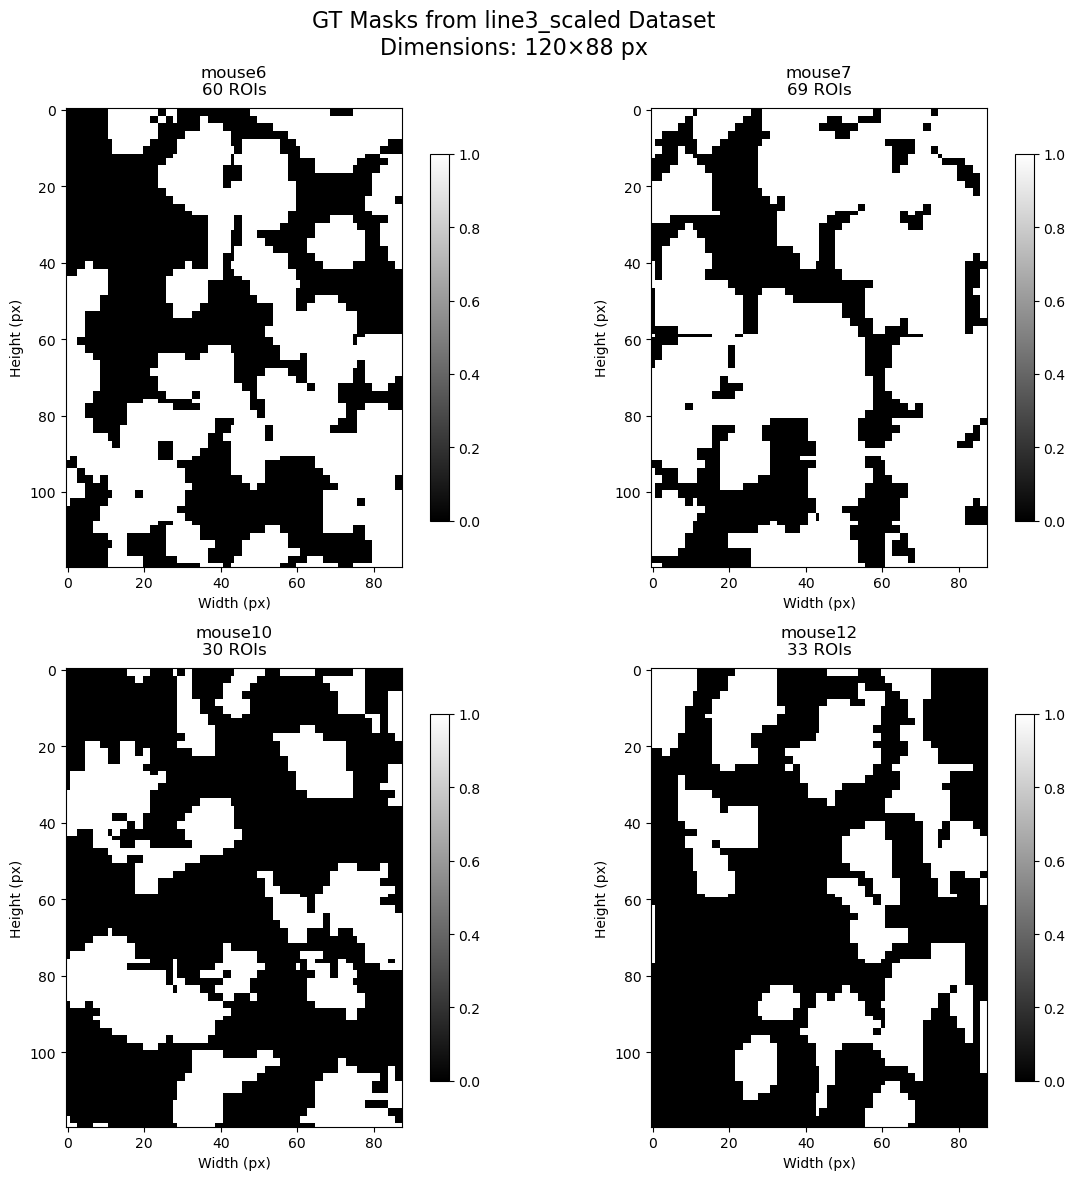


=== GT MASKS SUMMARY (line3_scaled) ===
Mouse    | Shape      | Total ROIs
-----------------------------------
mouse6   | (120, 88, 968) | 60
mouse7   | (120, 88, 1104) | 69
mouse10  | (120, 88, 611) | 30
mouse12  | (120, 88, 454) | 33


In [48]:
# Visualize GT masks from line3_scaled dataset (120×88)
if scaled_gt_data:
    n_mice = len(scaled_gt_data)
    cols = min(2, n_mice)
    rows = (n_mice + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6*rows))
    if n_mice == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, (vid_id, data) in enumerate(scaled_gt_data.items()):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        
        masks = data['masks']
        roi_count = data['roi_count']
        
        if masks is not None:
            combined_masks = create_combined_mask_image(masks)
            if combined_masks is not None:
                im = ax.imshow(combined_masks, cmap='gray', aspect='equal', vmin=0, vmax=1)
                ax.set_title(f"{vid_id}\n{roi_count} ROIs", fontsize=12, pad=10)
                ax.set_xlabel("Width (px)", fontsize=10)
                ax.set_ylabel("Height (px)", fontsize=10)
                plt.colorbar(im, ax=ax, shrink=0.8)
            else:
                ax.text(0.5, 0.5, 'No valid masks', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f"{vid_id}\n{roi_count} ROIs", fontsize=12, pad=10)
        else:
            ax.text(0.5, 0.5, 'Masks not found', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"{vid_id}\n{roi_count} ROIs", fontsize=12, pad=10)
    
    # Hide unused subplots
    for i in range(n_mice, rows * cols):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.axis('off')
    
    plt.suptitle(f"GT Masks from line3_scaled Dataset\nDimensions: 120×88 px", 
                 fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\n=== GT MASKS SUMMARY (line3_scaled) ===")
    print("Mouse    | Shape      | Total ROIs")
    print("-" * 35)
    for vid_id, data in scaled_gt_data.items():
        shape = data['masks'].shape if data['masks'] is not None else "N/A"
        roi_count = data['roi_count']
        print(f"{vid_id:<8} | {str(shape):<10} | {roi_count}")

else:
    print("No GT mask data available for visualization")


In [ ]:
## 7. Visualize Cropped Frames (120×88) from line3_scaled dataset


In [49]:
# Load and visualize the cropped frames (120×88) from line3_scaled dataset
print("=== LOADING CROPPED FRAMES FROM LINE3_SCALED ===")

# Load cropped frames for each mouse
cropped_frames_data = {}

for vid_id in line3_video_ids:
    print(f"\n--- Loading {vid_id} cropped frames ---")
    
    # Load cropped video (120×88)
    cropped_path = os.path.join(DATAFOLDER_SETS['line3_scaled'], f"{vid_id}.h5")
    if os.path.exists(cropped_path):
        try:
            with h5py.File(cropped_path, 'r') as f:
                dset_name = 'mov' if 'mov' in f else list(f.keys())[0]
                cropped_video = f[dset_name][:]
            
            # Calculate max frame
            cropped_max_frame = np.max(cropped_video, axis=0)
            T, H, W = cropped_video.shape
            
            print(f"Cropped video shape: {cropped_video.shape}")
            print(f"Max frame shape: {cropped_max_frame.shape}")
            
            cropped_frames_data[vid_id] = {
                'max_frame': cropped_max_frame,
                'video_shape': cropped_video.shape
            }
        except Exception as e:
            print(f"Error loading cropped video: {e}")
            cropped_frames_data[vid_id] = {'max_frame': None, 'video_shape': None}
    else:
        print(f"Cropped video not found: {cropped_path}")
        cropped_frames_data[vid_id] = {'max_frame': None, 'video_shape': None}

print(f"\n✓ Loaded cropped frames for {len(cropped_frames_data)} mice")


=== LOADING CROPPED FRAMES FROM LINE3_SCALED ===

--- Loading mouse6 cropped frames ---
Cropped video shape: (1600, 120, 88)
Max frame shape: (120, 88)

--- Loading mouse7 cropped frames ---
Cropped video shape: (1600, 120, 88)
Max frame shape: (120, 88)

--- Loading mouse10 cropped frames ---
Cropped video shape: (1600, 120, 88)
Max frame shape: (120, 88)

--- Loading mouse12 cropped frames ---
Cropped video shape: (1600, 120, 88)
Max frame shape: (120, 88)

✓ Loaded cropped frames for 4 mice


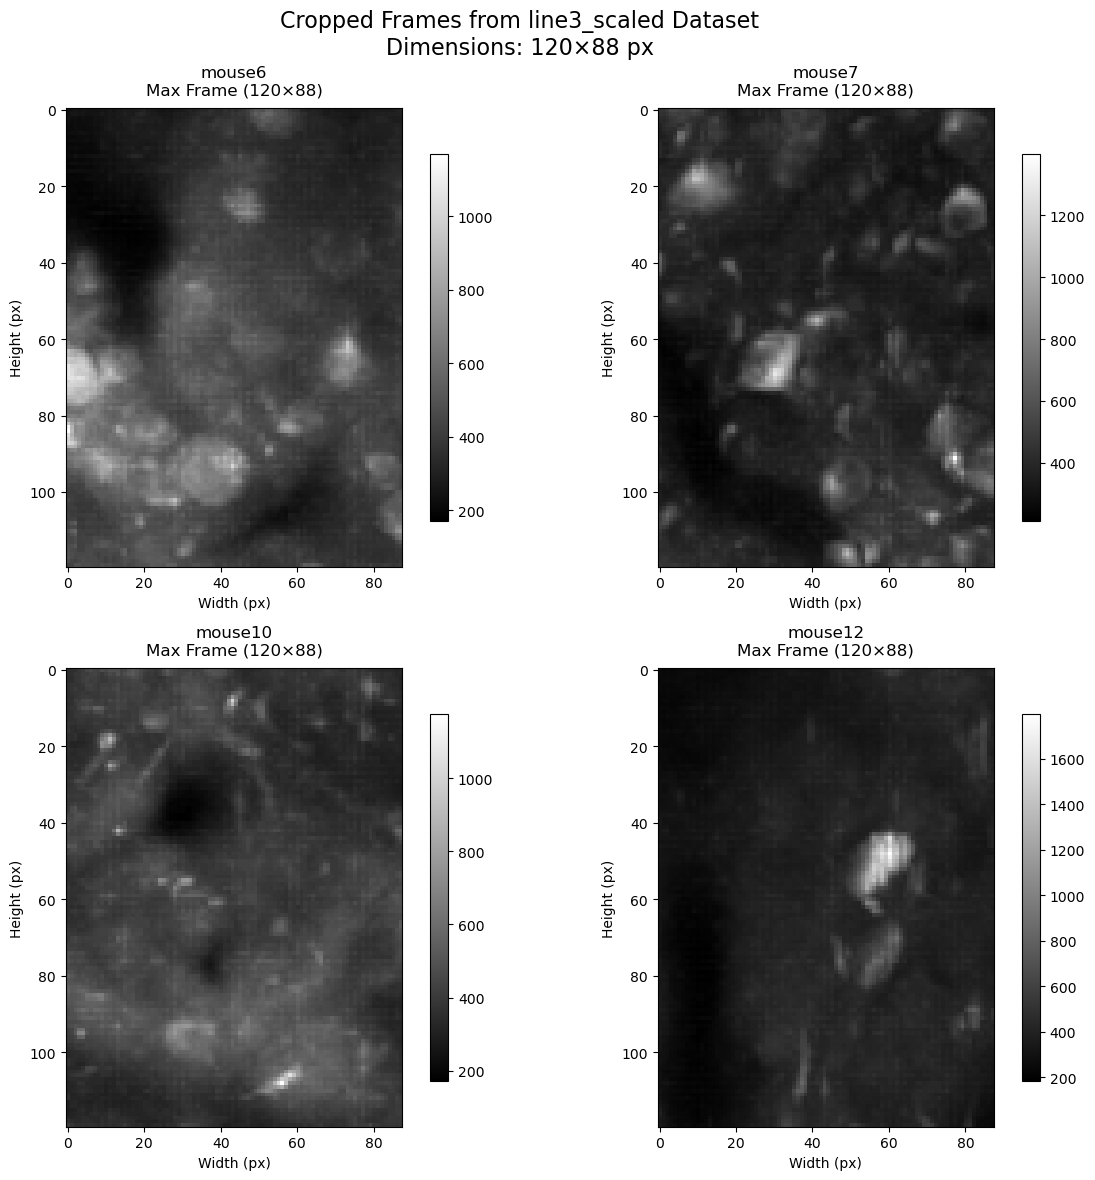


=== CROPPED FRAMES SUMMARY ===
Mouse    | Video Shape    | Frame Shape
----------------------------------------
mouse6   | (1600, 120, 88) | (120, 88)
mouse7   | (1600, 120, 88) | (120, 88)
mouse10  | (1600, 120, 88) | (120, 88)
mouse12  | (1600, 120, 88) | (120, 88)


In [50]:
# Visualize cropped frames (120×88) from line3_scaled dataset
if cropped_frames_data:
    n_mice = len(cropped_frames_data)
    cols = min(2, n_mice)
    rows = (n_mice + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6*rows))
    if n_mice == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, (vid_id, data) in enumerate(cropped_frames_data.items()):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        
        max_frame = data['max_frame']
        video_shape = data['video_shape']
        
        if max_frame is not None:
            im = ax.imshow(max_frame, cmap='gray', aspect='equal')
            ax.set_title(f"{vid_id}\nMax Frame (120×88)", fontsize=12, pad=10)
            ax.set_xlabel("Width (px)", fontsize=10)
            ax.set_ylabel("Height (px)", fontsize=10)
            plt.colorbar(im, ax=ax, shrink=0.8)
        else:
            ax.text(0.5, 0.5, 'Frame not found', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"{vid_id}\nMax Frame (120×88)", fontsize=12, pad=10)
    
    # Hide unused subplots
    for i in range(n_mice, rows * cols):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.axis('off')
    
    plt.suptitle(f"Cropped Frames from line3_scaled Dataset\nDimensions: 120×88 px", 
                 fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\n=== CROPPED FRAMES SUMMARY ===")
    print("Mouse    | Video Shape    | Frame Shape")
    print("-" * 40)
    for vid_id, data in cropped_frames_data.items():
        video_shape = data['video_shape'] if data['video_shape'] is not None else "N/A"
        frame_shape = data['max_frame'].shape if data['max_frame'] is not None else "N/A"
        print(f"{vid_id:<8} | {str(video_shape):<14} | {str(frame_shape)}")

else:
    print("No cropped frame data available for visualization")


In [ ]:
# === Visualize max projection + GT contours for line3_scaled (120×88) ===
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import cv2
from scipy.io import loadmat
from scipy.sparse import csc_matrix

# Use scaled dataset
exp_set = 'line3_scaled'
root = DATAFOLDER_SETS[exp_set]
scaled_ids = EXP_ID_SETS[exp_set]
vis_root = os.path.join(root, OUTPUT_FOLDER[exp_set], 'vis_max_gt')
os.makedirs(vis_root, exist_ok=True)

print(f"Visualizing max projection + GT for {exp_set} → {vis_root}")

def load_max_projection_from_h5(h5_path: str) -> np.ndarray:
    with h5py.File(h5_path, 'r') as f:
        dname = 'mov' if 'mov' in f else list(f.keys())[0]
        ds = f[dname]
        # Stream max projection to avoid loading entire video to RAM
        max_frame = None
        chunk = 200
        T = ds.shape[0]
        for s in range(0, T, chunk):
            e = min(s + chunk, T)
            blk = ds[s:e]
            m = blk.max(axis=0)
            if max_frame is None:
                max_frame = m
            else:
                max_frame = np.maximum(max_frame, m)
        return max_frame

def to_rgb_image(img2d: np.ndarray) -> np.ndarray:
    x = img2d.astype(np.float32)
    p = np.percentile(x, 99.5)
    if p <= 0:
        p = max(1.0, x.max())
    x = np.clip(x / p, 0, 1)
    u8 = (x * 255.0).astype(np.uint8)
    return np.stack([u8, u8, u8], axis=-1)

# Reuse helper from earlier cell: load_gt_masks_list(gt_mat_path, dims) returning (n_gt, Lx, Ly)

for vid in scaled_ids:
    video_path = os.path.join(root, f'{vid}.h5')
    gt_sparse_path = os.path.join(root, 'GT Masks', f'FinalMasks_{vid}_sparse.mat')
    if not os.path.exists(video_path):
        print(f"Skipping {vid}: video missing at {video_path}")
        continue
    if not os.path.exists(gt_sparse_path):
        print(f"Skipping {vid}: GT sparse missing at {gt_sparse_path}")
        continue

    print(f"\n--- {vid} ---")
    max_img = load_max_projection_from_h5(video_path)  # (120, 88)
    Lx, Ly = max_img.shape
    base_rgb = to_rgb_image(max_img)

    # Load GT masks as list (n_gt, Lx, Ly)
    try:
        gt_masks = load_gt_masks_list(gt_sparse_path, (Lx, Ly))
        n_gt = gt_masks.shape[0]
    except Exception as e:
        print(f"! GT load warning for {vid}: {e}")
        gt_masks = np.zeros((0, Lx, Ly), dtype=bool)
        n_gt = 0

    # Overlay labeled GT contours (white with green labels)
    over = draw_labeled_contours_for_masks(base_rgb, gt_masks, color=(255, 255, 255), text_color=(0, 255, 0), thickness=1)

    # Show inline and save
    plt.figure(figsize=(5, 5))
    plt.title(f"{vid} — MaxProj + GT (n={n_gt})")
    plt.imshow(over)
    plt.axis('off')
    plt.show()

    out_png = os.path.join(vis_root, f'{vid}_maxproj_gt.png')
    cv2.imwrite(out_png, cv2.cvtColor(over, cv2.COLOR_RGB2BGR))
    print(f"Saved: {out_png}")
